In [16]:
import warnings
import os
import joblib
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from python_speech_features import mfcc
from scipy.io import wavfile
from pydub import AudioSegment
from pydub.silence import split_on_silence

In [2]:
class ModelHMM(object):
    def __init__(self, num_components=8, num_iter=1000):
        self.n_components = num_components
        self.n_iter = num_iter
    # Define the covariance type and the type of HMM:
        self.cov_type = 'diag'
        self.model_name = 'GaussianHMM'
    # Initialize the variable in which we will store the models for each word:
        self.models = []
    # Define the model using the specified parameters:
        self.model = hmm.GaussianHMM(n_components=self.n_components,
                covariance_type=self.cov_type, n_iter=self.n_iter)

    # Define a method to train the model
    # 'training_data' is a 2D numpy array where each row has length of number of mfcc coefficients
    def train(self, training_data):
        np.seterr(all='ignore')
        cur_model = self.model.fit(training_data)
        self.models.append(cur_model)

    # Define a method to compute log likelihood score for input features
    def compute_score(self, input_data):
        return self.model.score(input_data)  # model.score returns log likelihood of sample input_data

In [3]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [4]:
def build_one_model(input_folder, num_states, num_cep_coeff):
    # input_folder: path to the folder containing training wav files with the word
    # num_states: number of hidden states in HMM
    # num_cep_coeff: number of MFCC features extracted from each time window
    X = np.array([])  # features
    training_files = [x for x in os.listdir(input_folder) if x.endswith('.wav')]
    for filename in training_files:
        # Extract the current filepath and read the file
        filepath = os.path.join(input_folder, filename)
        sampling_freq, signal = wavfile.read(filepath)
        sound = AudioSegment.from_file(filepath, format='wav')
        duration = len(sound)

        start_trim = detect_leading_silence(sound)
        end_trim = detect_leading_silence(sound.reverse())
        duration = len(sound)
        trimmed_sound = sound[start_trim:duration - end_trim]
        if len(trimmed_sound) < 150:
            continue
        trimmed_sound.export('tmp.wav', format='wav')
        # Extract features
        # Default values:
        # winlen=0.025, winstep=0.01, nfft=512,
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            features_mfcc = mfcc(signal, sampling_freq, numcep=num_cep_coeff)

        # Append features to the variable X
        if len(X) == 0:
            X = features_mfcc
        else:
            X = np.append(X, features_mfcc, axis=0)

    # Initiate HMM model object
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        model = ModelHMM(num_components=num_states)

    # Train HMM model, calculate likelihood of the sample by the trained model
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        model.train(X)
        model_score = model.compute_score(X)

    return model, model_score, num_cep_coeff

In [5]:
def build_models(input_folder):

    # input_folder contains subfolders with samples of words in wav files

    # Initialize the variable to store all the models
    speech_models = []

    # Parse the input directory
    for dirname in os.listdir(input_folder):

        # Get name of subfolder
        subfolder = os.path.join(input_folder, dirname)

        if not os.path.isdir(subfolder):
            continue

        # Extract label
        label = subfolder[subfolder.rfind('/') + 1:]

        # Fit model for label
        model = build_one_model(subfolder, num_states=num_components, num_cep_coeff=num_cepstr)

        # Add the model to the list
        speech_models.append((model, label))

        # Reset model variable
        model = None
        print('Fitted '+dirname)
    return speech_models

In [61]:
input_folder = './MNIST_9-25'
num_components = 17
num_cepstr = 17

digit_models = build_models(input_folder)

Fitted num0
Fitted num1
Fitted num2
Fitted num3
Fitted num4
Fitted num5
Fitted num6
Fitted num7
Fitted num8
Fitted num9


In [62]:
joblib.dump(digit_models,'speech.pkl')

['speech.pkl']

In [63]:
speech_models = joblib.load('speech.pkl')

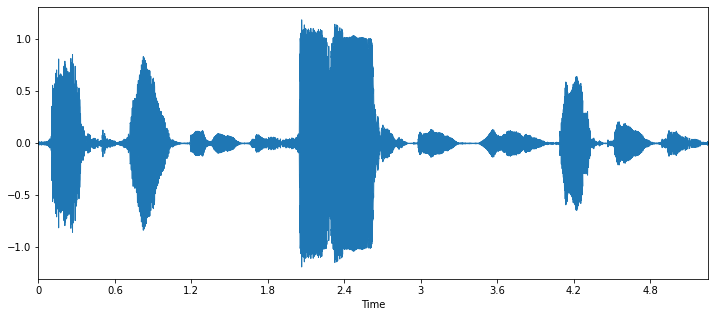

Signal rate = 22050


In [9]:
wav_file = './test/217.wav'
x, sr = librosa.load(wav_file)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()
print('Signal rate =',sr)

In [10]:
def get_silence_len(sound, thresh):
    i = 1
    step = 5
    cur_len = -step
    cur_num = 0
    while cur_num != 10:
        cur_len += step
        audio_chunks = split_on_silence(sound, min_silence_len=cur_len, silence_thresh=thresh)
        cur_num = len(audio_chunks)
        if cur_len > 300:
            cur_len = -step + i
            i += 1
        if i == step:
            print('There is no such silence length! Returning 50.')
            return 50
    return cur_len

In [11]:
wav_file = './test/0.wav'
sound_file = AudioSegment.from_wav(wav_file)        
thresh = -40
silence_len = get_silence_len(sound_file, thresh)
print(silence_len)

125


In [12]:
def score_one_word(trained_model, test_file_path):
    # trained_model: ModelHMM object with trained model
    # test_file_path: path to wav file

    sampling_freq, signal = wavfile.read(test_file_path)
    num_cep_coeff = trained_model[2]

    # Extract features
    # Default values:
    # winlen=0.025, winstep=0.01, nfilt=26, nfft=512,
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        features_mfcc = mfcc(signal, sampling_freq, numcep=num_cep_coeff)

        # Calculate log likelihood
        word_score = trained_model[0].compute_score(features_mfcc)
    return word_score

In [64]:
numbers = pd.DataFrame()
test_files = [x for x in os.listdir('test') if x.endswith('.wav')]
thresh = -40
for filename in test_files:
    phone_number = ''
    sound_file = AudioSegment.from_wav('./test/' + filename)        
    audio_chunks = split_on_silence(sound_file, min_silence_len=get_silence_len(sound_file, thresh), silence_thresh=thresh)
    for chunk in audio_chunks:
        chunk.export(out_f = 'tmp.wav', format = 'wav')
        max_score = -float('inf')
        for item in speech_models:
            model, label = item
            cur_score = score_one_word(model, 'tmp.wav')
            if cur_score > max_score:
                predicted_label = label #label which has highest score
                max_score = cur_score
        phone_number += predicted_label[-1]
    print(filename + ' Done')
    res = {'index': int(filename.split('.')[0]), 'number': phone_number}
    if len(numbers)==0:
        numbers = pd.DataFrame([res])
    else:
        numbers = numbers.append([res], ignore_index=True)

0.wav Done
1.wav Done
10.wav Done
100.wav Done
101.wav Done
102.wav Done
103.wav Done
104.wav Done
105.wav Done
106.wav Done
107.wav Done
108.wav Done
109.wav Done
11.wav Done
110.wav Done
111.wav Done
112.wav Done
113.wav Done
114.wav Done
115.wav Done
116.wav Done
117.wav Done
118.wav Done
119.wav Done
12.wav Done
120.wav Done
121.wav Done
122.wav Done
123.wav Done
124.wav Done
125.wav Done
126.wav Done
127.wav Done
128.wav Done
129.wav Done
13.wav Done
130.wav Done
131.wav Done
132.wav Done
133.wav Done
134.wav Done
135.wav Done
136.wav Done
137.wav Done
138.wav Done
139.wav Done
14.wav Done
140.wav Done
141.wav Done
142.wav Done
143.wav Done
144.wav Done
145.wav Done
146.wav Done
147.wav Done
148.wav Done
149.wav Done
15.wav Done
150.wav Done
151.wav Done
152.wav Done
153.wav Done
154.wav Done
155.wav Done
156.wav Done
157.wav Done
158.wav Done
159.wav Done
16.wav Done
160.wav Done
161.wav Done
162.wav Done
163.wav Done
164.wav Done
165.wav Done
166.wav Done
167.wav Done
168.wav Do

In [65]:
numbers.sort_values(by='index', inplace=True)
print(numbers)

     index      number
0        0  7641720038
1        1  4148851786
112      2  6661727512
223      3  4505659702
234      4  6998185446
..     ...         ...
218    295  3678833913
219    296  8548343577
220    297  4369008198
221    298  0821757754
222    299  9526398486

[300 rows x 2 columns]


In [66]:
numbers.to_csv('ans_5.csv', index=False, header=False)